In [1]:
import transformers


In [2]:
# sentiment analysis with the pipeline
from transformers import pipeline


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess_kgptalkie as ps

In [5]:

df = pd.read_csv("twitter.csv")
df = df.sample(500)
df.head()

,id,entity,target,text
52749,10662,RedDeadRedemption(RDR),Neutral,Huntin critters in Red Dead Redemption 2 twitc...
45533,11816,Verizon,Positive,you @verizon for giving me no data limits on t...
58355,3205,Facebook,Positive,more
55679,2358,CallOfDuty,Irrelevant,have
30077,770,ApexLegends,Neutral,Positioning is based


In [6]:
df.drop(columns=['id','entity'],inplace=True)

In [7]:
df.shape
df.isnull().sum()

target    0
text      6
dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
mao={'Irrelevant':'Neutral'}
df['target'] = df['target'].replace(mao)

In [12]:
df['target'].value_counts()

target
Neutral     221
Negative    147
Positive    125
Name: count, dtype: int64

In [13]:

# preprocessing
df['word_counts'] = df['text'].apply(lambda x: ps.get_wordcounts(x))
df['char_counts'] = df['text'].apply(lambda x: ps.get_charcounts(x))
#df['avg_wordlength'] = df['text'].apply(lambda x: ps.get_avg_wordlength(x))
df['stopwords_counts'] = df['text'].apply(lambda x: ps.get_stopwords_counts(x))

In [14]:

df['text'] = df['text'].str.lower()

df.head()

,target,text,word_counts,char_counts,stopwords_counts
52749,Neutral,huntin critters in red dead redemption 2 twitc...,8,54,1
45533,Positive,you @verizon for giving me no data limits on t...,15,70,8
58355,Positive,more,1,4,1
55679,Neutral,have,1,4,1
30077,Neutral,positioning is based,3,18,1


<Axes: >

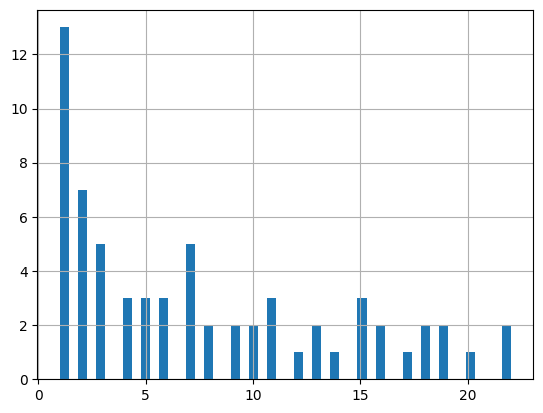

In [15]:
df['word_counts'].value_counts().hist(bins=50)

In [16]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [17]:
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=512):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length",
                              max_length=self.max_len)

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': label
    }

In [18]:
# prepare tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
X = df['text'].tolist()

label2id = {'Positive': 2, 'Negative': 0,'Neutral':1}
id2label = {2: 'Positive', 0: 'Negative',1:'Neutral'}

y = df['target'].map(label2id).tolist()

dataset = CustomDataset(X, y, tokenizer)

In [20]:
dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [21]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [22]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(example):
  labels = example.label_ids
  preds = example.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {'accuracy': acc, "f1": f1}

In [23]:
from transformers import Trainer, TrainingArguments
batch_size = 10
model_name = "distilbert_finetuned_setiment"

args = TrainingArguments(
    output_dir = "output",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size = batch_size,
    learning_rate = 2e-5,
    num_train_epochs = 1,
    evaluation_strategy = 'epoch'
)

c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics=compute_metrics,
                  tokenizer = tokenizer)

In [25]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are of type long

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len)

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': label
        }


In [26]:
X = df['text'].tolist()
y = df['target'].map(label2id).tolist()

train_dataset = CustomDataset(X, y, tokenizer)


In [27]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
trainer.train()


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 1.0028786659240723, 'eval_accuracy': 0.4444444444444444, 'eval_f1': 0.29541073515273464, 'eval_runtime': 36.0099, 'eval_samples_per_second': 2.749, 'eval_steps_per_second': 0.278, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

In [112]:
trainer.save_model(model_name)

In [113]:
text = "i love this product"
pipe = pipeline('text-classification', model_name)
pipe(text)

[{'label': 'LABEL_2', 'score': 0.8074092864990234}]

In [114]:
id2label

{2: 'Positive', 0: 'Negative', 1: 'Neutral'}

In [115]:

tok = AutoTokenizer.from_pretrained(model_name)
mod = AutoModelForSequenceClassification.from_pretrained(model_name)

In [117]:
def get_prediction(text):
  input_ids = tok.encode(text, return_tensors='pt')
  output = mod(input_ids)

  preds = torch.nn.functional.softmax(output.logits, dim=-1)

  prob = torch.max(preds).item()

  idx = torch.argmax(preds).item()
  sentiment = id2label[idx]

  return {'sentiment':sentiment, 'score':prob}

In [118]:
text = "i love this product"
get_prediction(text)


{'sentiment': 'Positive', 'score': 0.8074092864990234}

In [119]:
text = "i hate this product"
get_prediction(text)

{'sentiment': 'Negative', 'score': 0.8056272268295288}

In [122]:

import pickle

with open('dbm.pkl', 'wb') as file:
   pickle.dump(model, file)